In [1]:
import torch
import numpy as np 
import torch.nn as nn
from torchvision import utils
import matplotlib.pyplot as plt 

In [2]:
from torchvision import datasets, transforms

train_set = datasets.MNIST(
    root='./data/MNIST',
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = datasets.MNIST(
    root='./data/MNIST_test',
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)


In [3]:
def show_batch(batch):
    grid = utils.make_grid(batch.detach(), nrow=25)
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

In [4]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

LATETNT_SIZE = 20 

In [5]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size=LATETNT_SIZE):
        super(VAE, self).__init__()
        self.input_size = input_size # H*W
        self.latent_size = latent_size # Z
        self.hidden_dim = 100
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.input_size, out_features=self.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
          )
        self.mu_layer = nn.Linear(in_features=self.hidden_dim, out_features=self.latent_size)
        #self.logvar_layer = nn.Linear(in_features=self.hidden_dim, out_features=self.latent_size)
        self.log_cholesky_layer = nn.Linear(in_features=self.hidden_dim, out_features=self.latent_size*self.latent_size) 

        self.decoder = nn.Sequential(
          nn.Linear(in_features=self.latent_size, out_features=self.hidden_dim),
          nn.ReLU(),
          nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim),
          nn.ReLU(),
          nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim),
          nn.ReLU(),
          nn.Linear(in_features=self.hidden_dim, out_features=self.input_size),
          nn.Sigmoid()
          )

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu_layer(encoded)
        #logvar = self.logvar_layer(enoded)
        log_cholesky = self.log_cholesky_layer(encoded)
        #z = reparametrize(mu, logvar)
        z = full_cov_reparamertrive(mu, log_cholesky)
        x_hat = self.decoder(z).view(x.shape)
        return x_hat, mu, log_cholesky
        #return x_hat, mu, logvar

In [6]:
def reparametrize(mu, logvar):
    std = torch.sqrt(torch.exp(logvar)) 
    eps = torch.normal(0, 1, size=mu.shape).to(mu.device)
    z = mu + eps*std
    return z

In [7]:
def full_cov_reparamertrive(mu, log_ch):
  cholesky = torch.exp(log_ch)
  N, D = cholesky.shape 
  d = LATETNT_SIZE 
  cholesky = cholesky.reshape((-1, d, d))
  eps = torch.normal(0, 1, size=mu.shape).to(mu.device)
  z = mu + torch.bmm(cholesky, eps.unsqueeze(2)).squeeze() 
  return z 

In [8]:
def loss_function(x_hat, x, mu, logvar):
    KL_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x,  reduction='sum')
    loss = reconstruction_loss+KL_loss
    return loss

In [9]:
def full_covariate_loss_function(x_hat, x, mu, log_ch):
  cholesky = torch.exp(log_ch)
  N, D = cholesky.shape
  
  d = LATETNT_SIZE 
  cholesky = cholesky.reshape((-1, d, d))

  sigma = torch.bmm(cholesky, cholesky.permute(0, 2, 1))

  KL_loss = 0.5*((mu*mu).sum(dim=1).sum() + torch.sum(sigma*torch.eye(d).to(sigma.device))- d*N - torch.log(torch.det(sigma)).sum())

  reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x,  reduction='sum')
  loss = reconstruction_loss+KL_loss
  return loss 

In [12]:
def train_vae(model, train_data):
    print("Original test examples")
    first_batch = next(iter(test_loader))
    first_images, _ = first_batch
    show_batch(first_images[:10])

    lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    n_epochs = 100
    model.train()
    model.to(device)
    for epoch in range(n_epochs):
      ep_loss = 0.0
      for batch in train_data:
          batch_images, _ = batch
          batch_images = batch_images.to(device)
          
          # batch_output, mean, log_var = model(batch_images)
          # loss = loss_function(batch_output, batch_images, mean, log_var)
          batch_output, mean, log_cholesky = model(batch_images)
          loss = full_covariate_loss_function(batch_output, batch_images, mean, log_cholesky)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          ep_loss += loss.item() 
      print(f"the loss after processing epoch {epoch+1} is: {ep_loss}")
      print("showing examples ... ")

      first_images = first_images.to(device)
      recs, _, _ = vae(first_images)
      recs = recs.reshape(batch_size, 1, 28, 28)
      recs = recs.cpu()
      show_batch(recs[:10])


      if epoch % 10 == 0:
          lr /= 2
          optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model

Original test examples


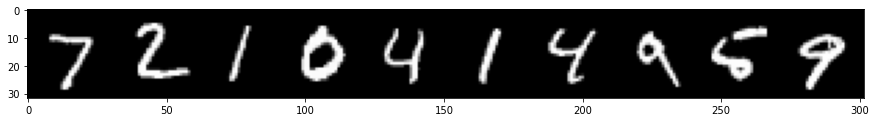

the loss after processing epoch 1 is: nan
showing examples ... 


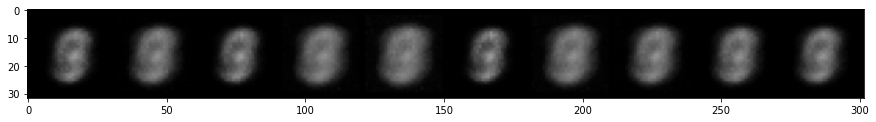

the loss after processing epoch 2 is: 12110473.7578125
showing examples ... 


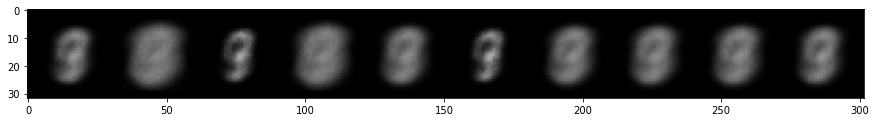

the loss after processing epoch 3 is: 11869897.5625
showing examples ... 


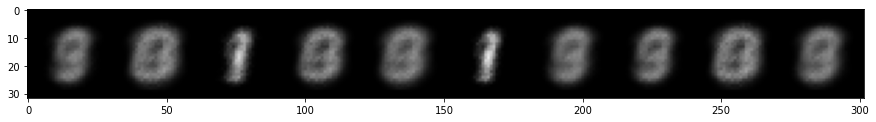

the loss after processing epoch 4 is: 11528731.875
showing examples ... 


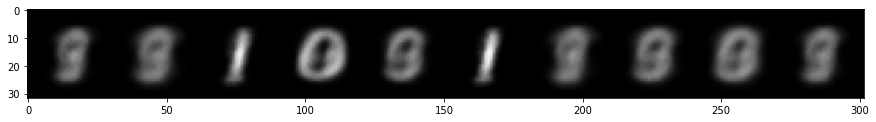

the loss after processing epoch 5 is: 11394963.703125
showing examples ... 


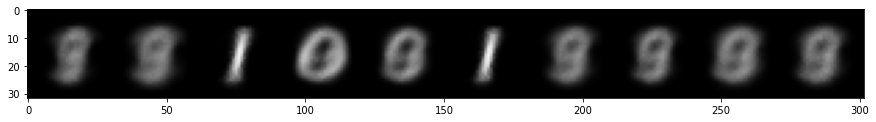

the loss after processing epoch 6 is: 11291942.953125
showing examples ... 


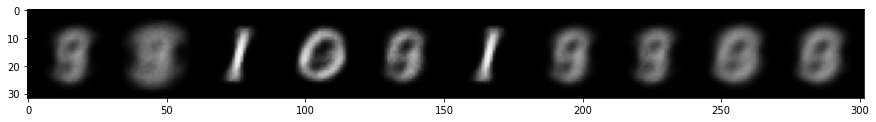

the loss after processing epoch 7 is: 11156594.8515625
showing examples ... 


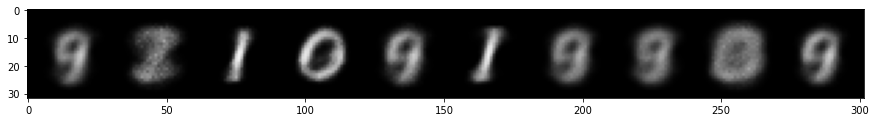

the loss after processing epoch 8 is: 10895204.21875
showing examples ... 


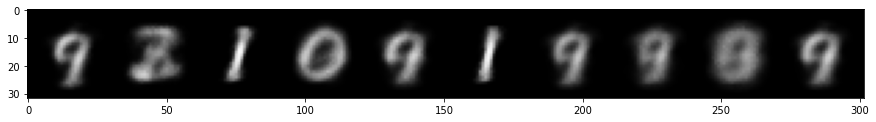

the loss after processing epoch 9 is: 10663884.1953125
showing examples ... 


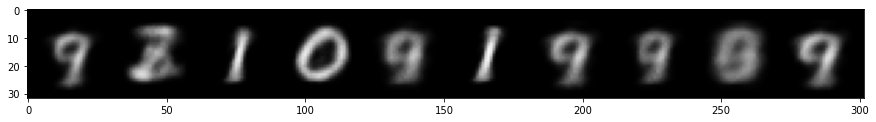

the loss after processing epoch 10 is: 10523530.0625
showing examples ... 


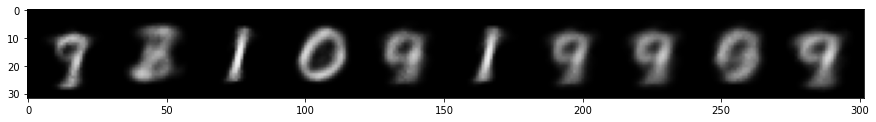

the loss after processing epoch 11 is: 10382257.4765625
showing examples ... 


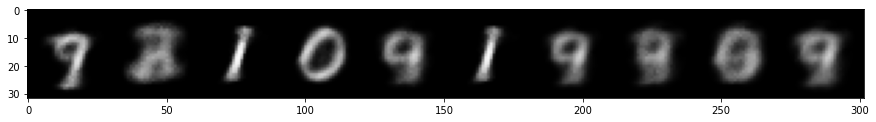

the loss after processing epoch 12 is: 10250496.4609375
showing examples ... 


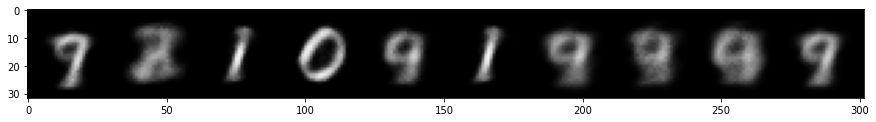

the loss after processing epoch 13 is: 10092896.421875
showing examples ... 


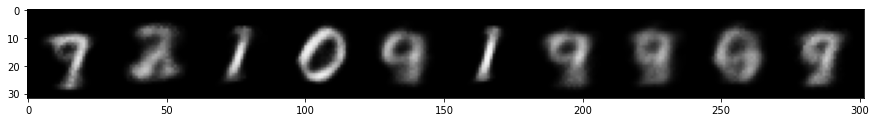

the loss after processing epoch 14 is: 9916895.765625
showing examples ... 


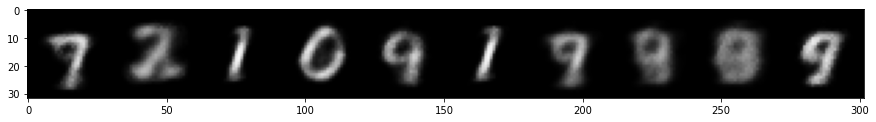

the loss after processing epoch 15 is: 9751370.5625
showing examples ... 


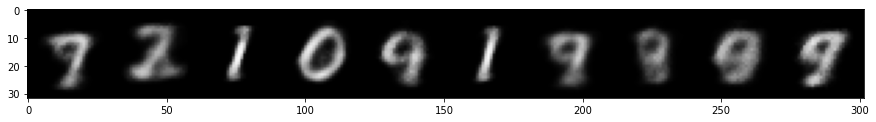

the loss after processing epoch 16 is: 9629920.609375
showing examples ... 


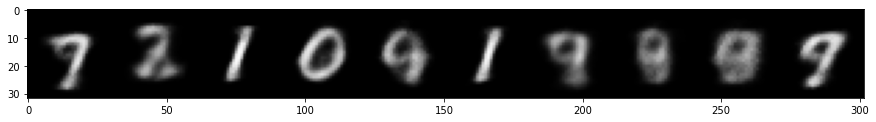

the loss after processing epoch 17 is: 9535321.5078125
showing examples ... 


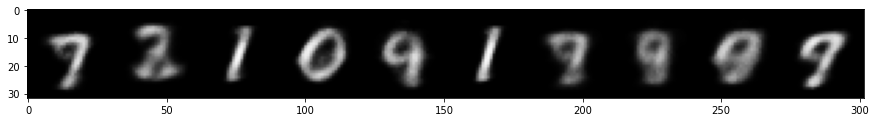

the loss after processing epoch 18 is: 9457134.2265625
showing examples ... 


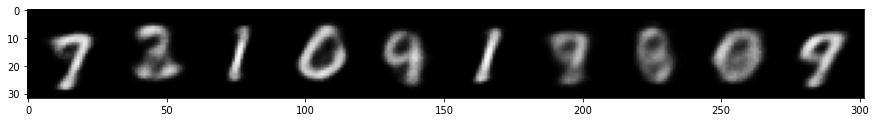

the loss after processing epoch 19 is: 9389925.515625
showing examples ... 


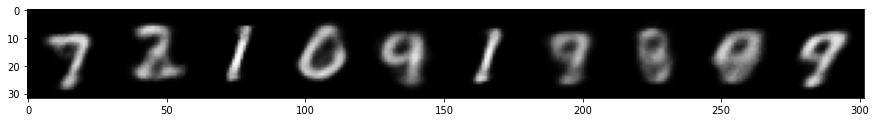

the loss after processing epoch 20 is: 9325348.1015625
showing examples ... 


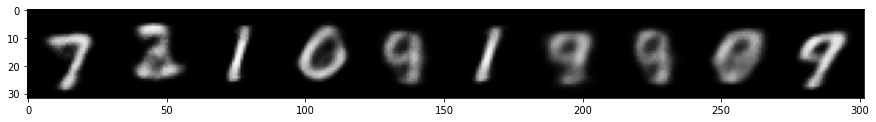

the loss after processing epoch 21 is: 9246603.6796875
showing examples ... 


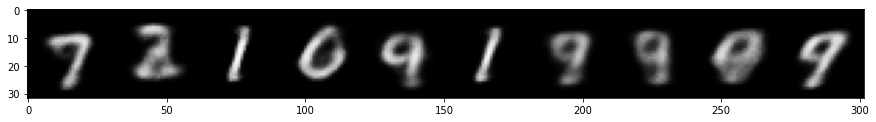

the loss after processing epoch 22 is: 9180323.5546875
showing examples ... 


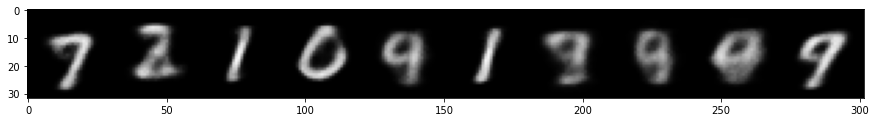

the loss after processing epoch 23 is: 9129580.53125
showing examples ... 


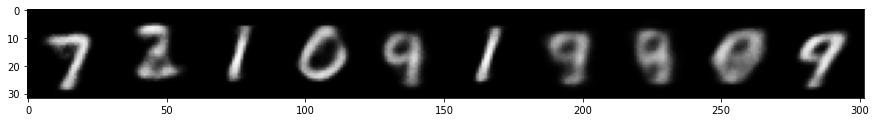

the loss after processing epoch 24 is: 9078585.03125
showing examples ... 


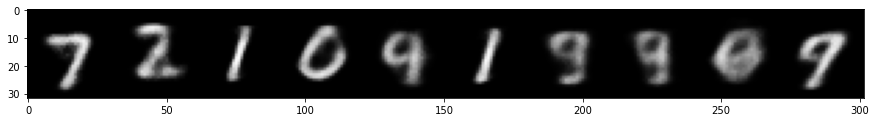

the loss after processing epoch 25 is: 9026519.75
showing examples ... 


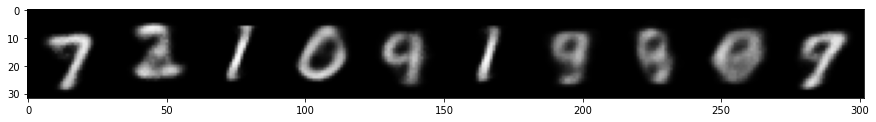

the loss after processing epoch 26 is: 8979591.3046875
showing examples ... 


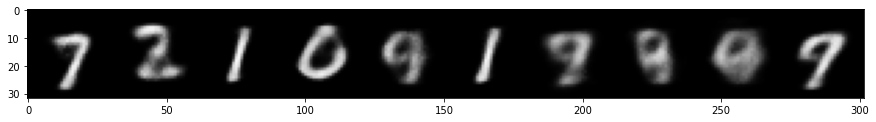

the loss after processing epoch 27 is: 8936983.75
showing examples ... 


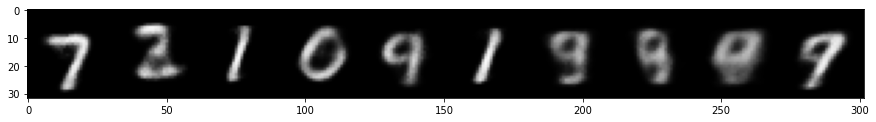

the loss after processing epoch 28 is: 8900074.4921875
showing examples ... 


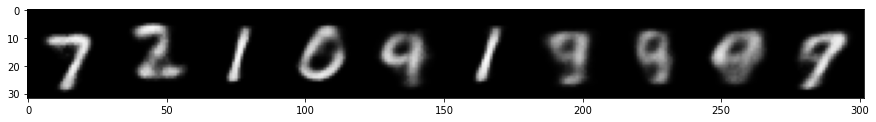

the loss after processing epoch 29 is: 8871440.0546875
showing examples ... 


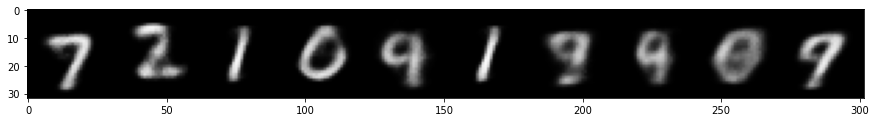

the loss after processing epoch 30 is: 8841248.2578125
showing examples ... 


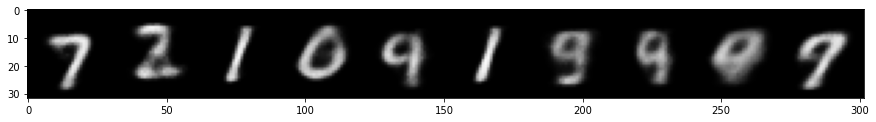

the loss after processing epoch 31 is: 8814528.109375
showing examples ... 


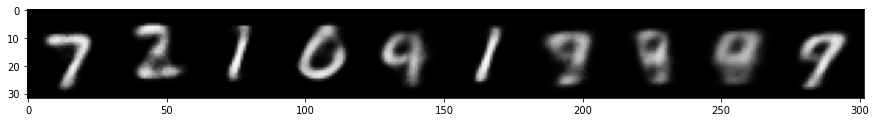

the loss after processing epoch 32 is: 8796417.5234375
showing examples ... 


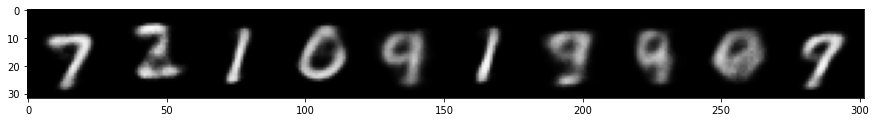

the loss after processing epoch 33 is: 8782766.2578125
showing examples ... 


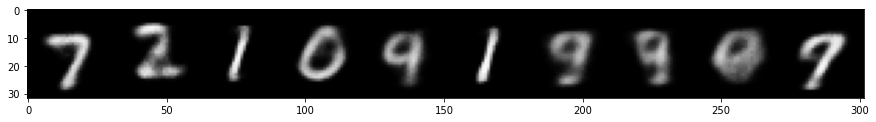

the loss after processing epoch 34 is: 8772480.71875
showing examples ... 


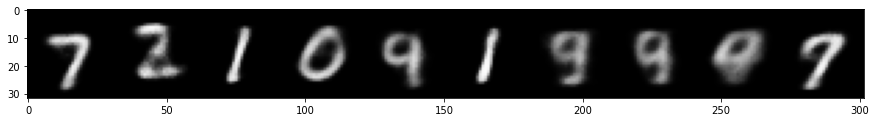

the loss after processing epoch 35 is: 8760195.28125
showing examples ... 


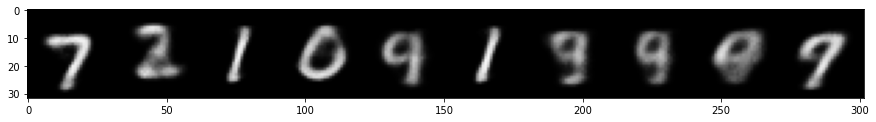

the loss after processing epoch 36 is: 8750358.5546875
showing examples ... 


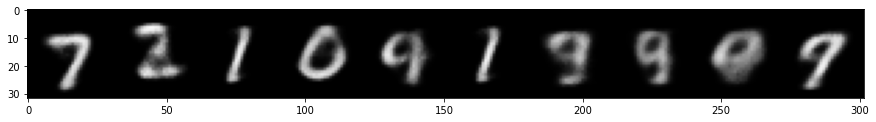

the loss after processing epoch 37 is: 8739780.703125
showing examples ... 


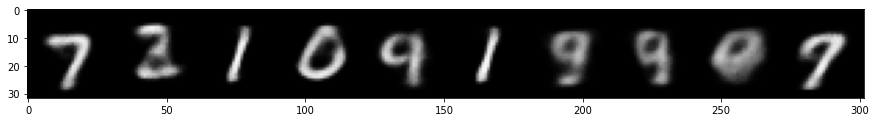

the loss after processing epoch 38 is: 8728978.734375
showing examples ... 


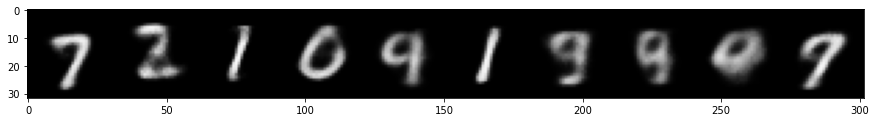

the loss after processing epoch 39 is: 8719637.09375
showing examples ... 


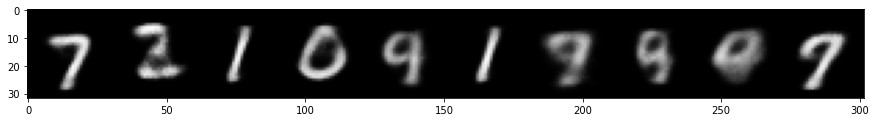

the loss after processing epoch 40 is: 8709674.296875
showing examples ... 


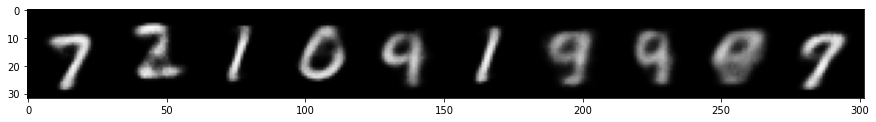

the loss after processing epoch 41 is: 8699989.484375
showing examples ... 


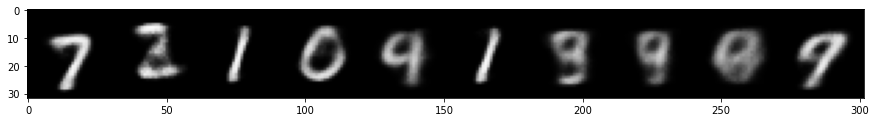

the loss after processing epoch 42 is: 8691484.09375
showing examples ... 


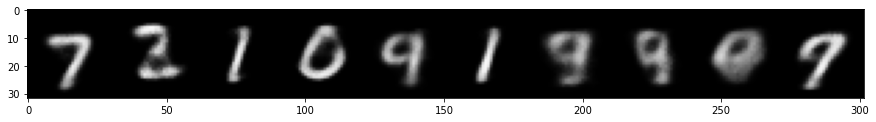

the loss after processing epoch 43 is: 8685947.34375
showing examples ... 


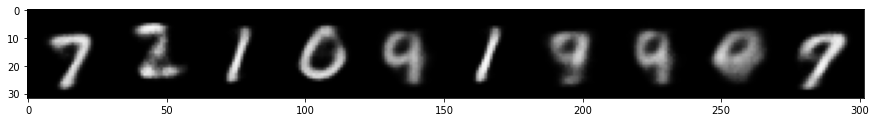

the loss after processing epoch 44 is: 8679951.21875
showing examples ... 


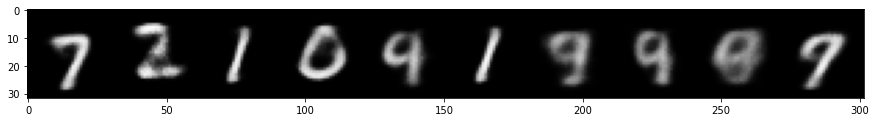

the loss after processing epoch 45 is: 8675591.453125
showing examples ... 


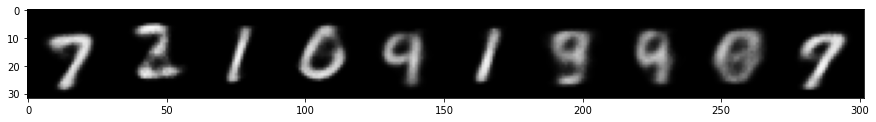

the loss after processing epoch 46 is: 8670333.28125
showing examples ... 


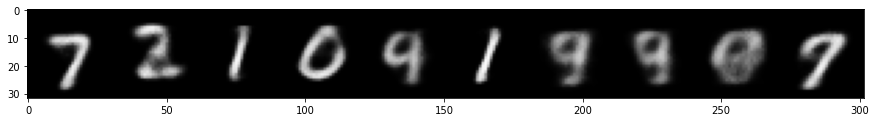

the loss after processing epoch 47 is: 8666198.8984375
showing examples ... 


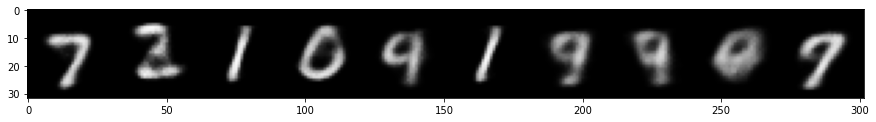

the loss after processing epoch 48 is: 8660545.21875
showing examples ... 


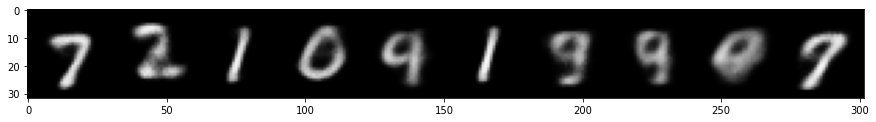

the loss after processing epoch 49 is: 8655421.6875
showing examples ... 


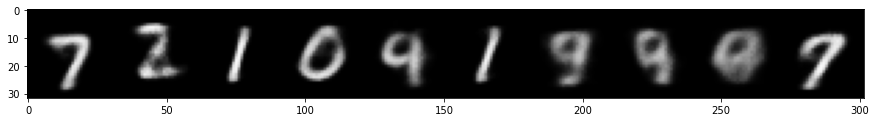

the loss after processing epoch 50 is: 8650536.46875
showing examples ... 


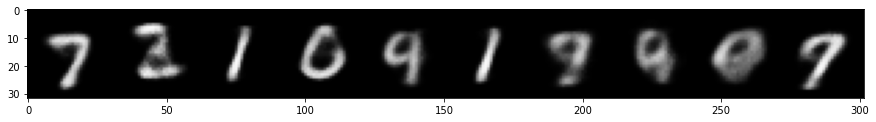

the loss after processing epoch 51 is: 8645702.28125
showing examples ... 


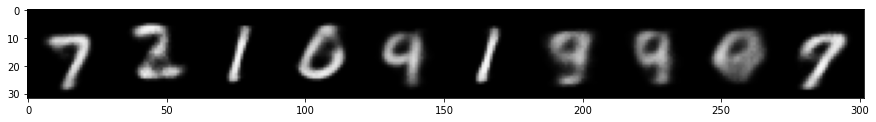

the loss after processing epoch 52 is: 8642305.28125
showing examples ... 


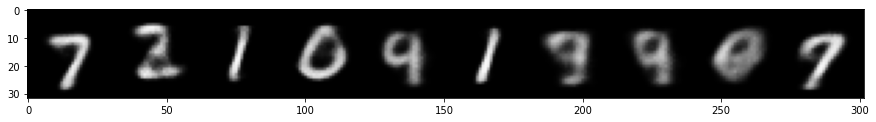

the loss after processing epoch 53 is: 8639224.3828125
showing examples ... 


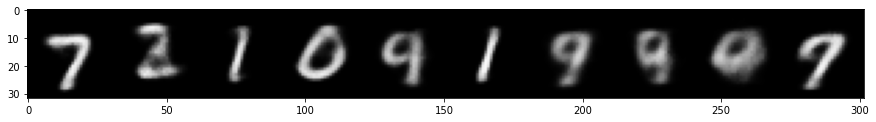

the loss after processing epoch 54 is: 8636686.53125
showing examples ... 


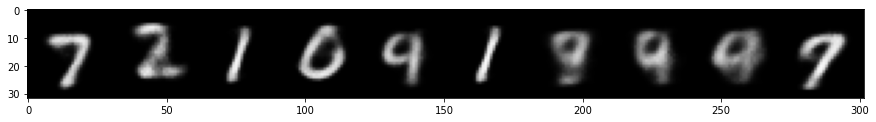

the loss after processing epoch 55 is: 8635058.046875
showing examples ... 


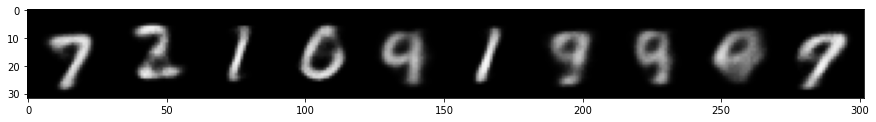

the loss after processing epoch 56 is: 8633172.28125
showing examples ... 


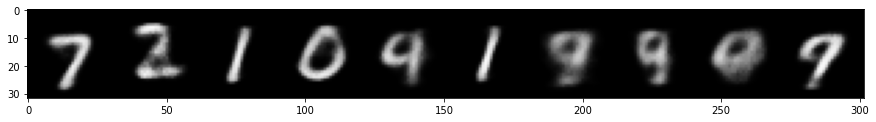

the loss after processing epoch 57 is: 8630340.28125
showing examples ... 


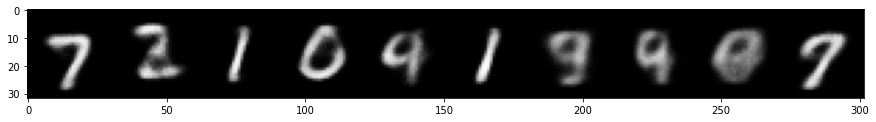

the loss after processing epoch 58 is: 8626165.1015625
showing examples ... 


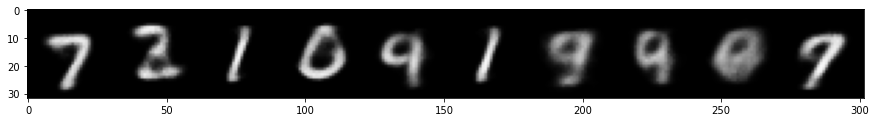

the loss after processing epoch 59 is: 8623252.6015625
showing examples ... 


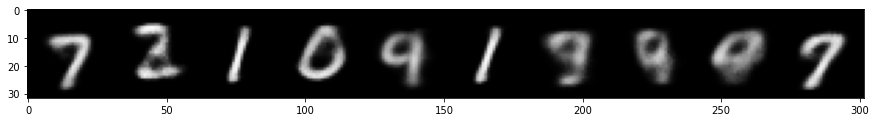

the loss after processing epoch 60 is: 8622548.171875
showing examples ... 


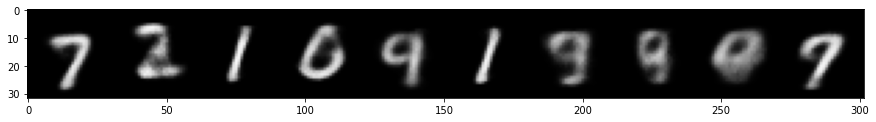

the loss after processing epoch 61 is: 8621513.890625
showing examples ... 


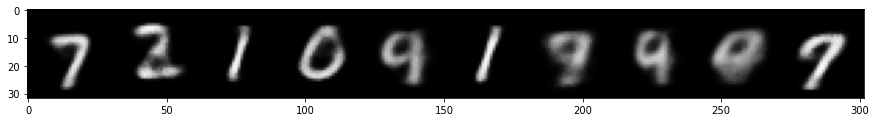

the loss after processing epoch 62 is: 8619053.671875
showing examples ... 


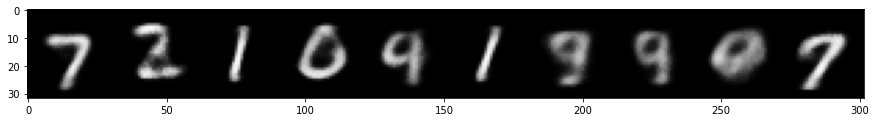

the loss after processing epoch 63 is: 8615614.6171875
showing examples ... 


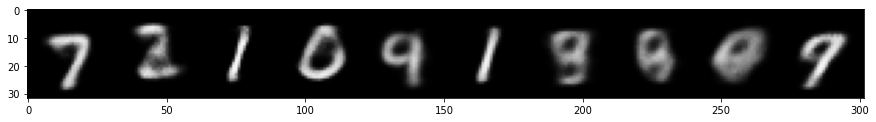

the loss after processing epoch 64 is: 8614824.3984375
showing examples ... 


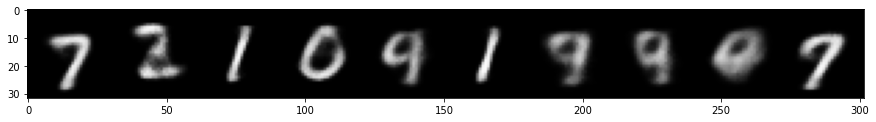

the loss after processing epoch 65 is: 8613596.6484375
showing examples ... 


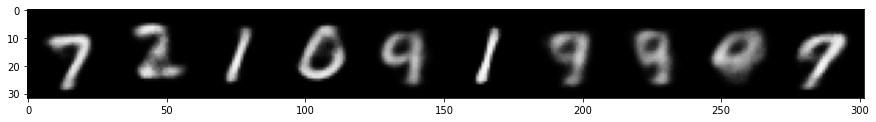

the loss after processing epoch 66 is: 8612114.9375
showing examples ... 


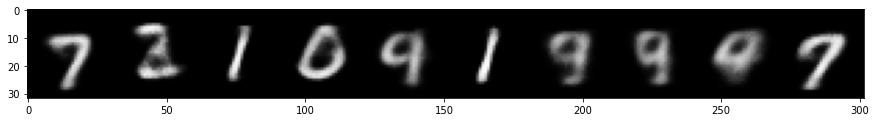

the loss after processing epoch 67 is: 8610670.6171875
showing examples ... 


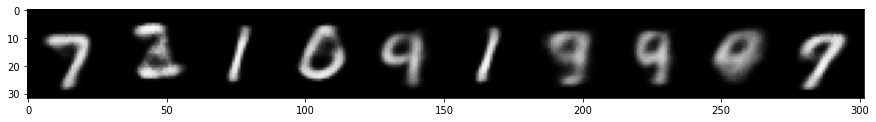

the loss after processing epoch 68 is: 8609225.5
showing examples ... 


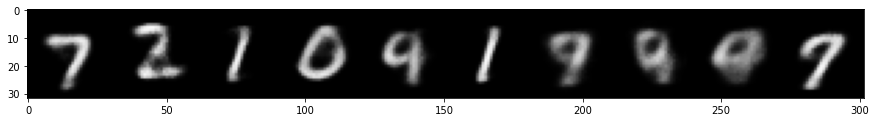

the loss after processing epoch 69 is: 8610249.8203125
showing examples ... 


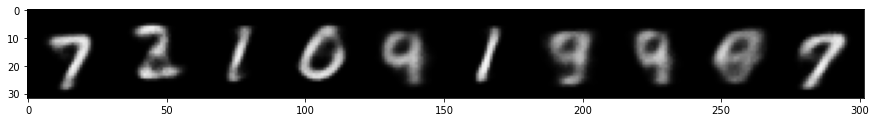

the loss after processing epoch 70 is: 8607636.046875
showing examples ... 


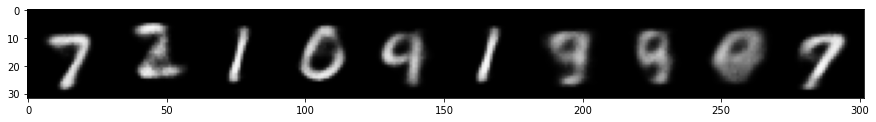

the loss after processing epoch 71 is: 8606859.109375
showing examples ... 


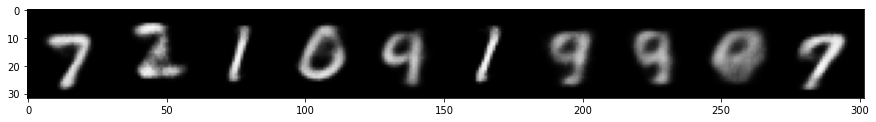

the loss after processing epoch 72 is: 8605474.390625
showing examples ... 


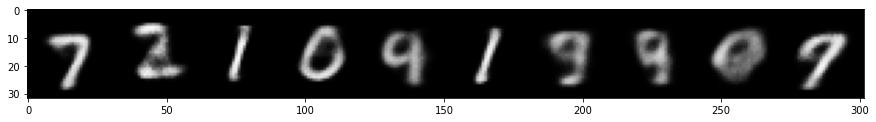

the loss after processing epoch 73 is: 8605061.2265625
showing examples ... 


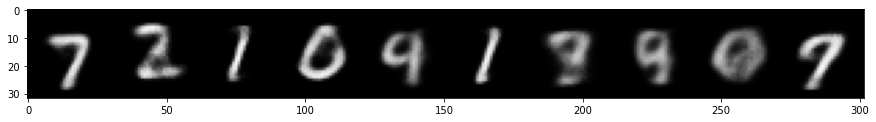

the loss after processing epoch 74 is: 8602006.859375
showing examples ... 


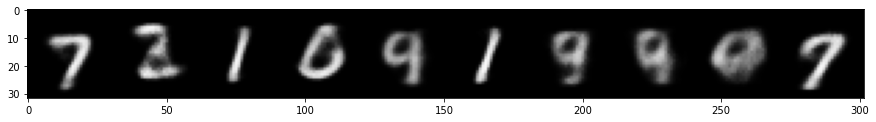

the loss after processing epoch 75 is: 8601807.9375
showing examples ... 


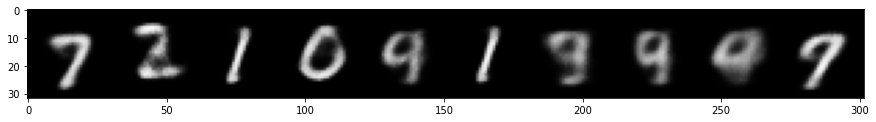

the loss after processing epoch 76 is: 8601563.4609375
showing examples ... 


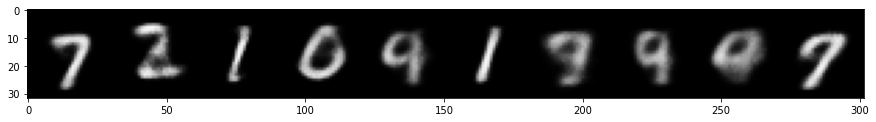

the loss after processing epoch 77 is: 8602638.0546875
showing examples ... 


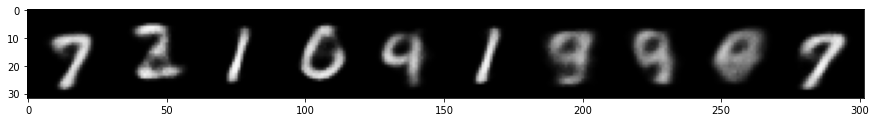

the loss after processing epoch 78 is: 8601601.5859375
showing examples ... 


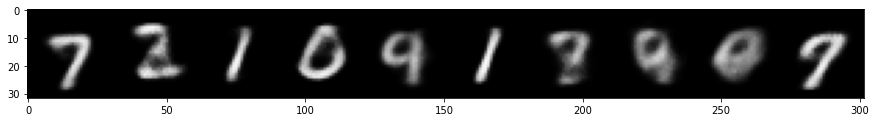

the loss after processing epoch 79 is: 8600788.96875
showing examples ... 


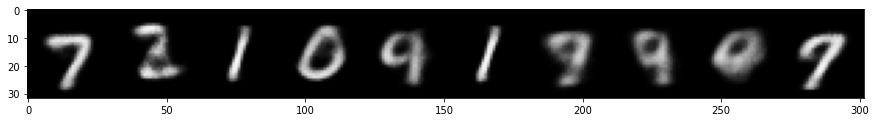

the loss after processing epoch 80 is: 8600084.4296875
showing examples ... 


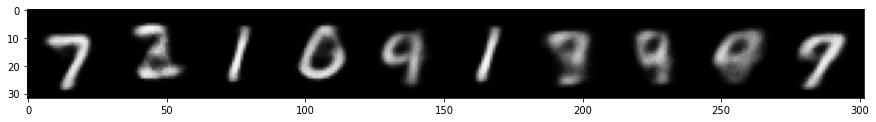

the loss after processing epoch 81 is: 8599685.734375
showing examples ... 


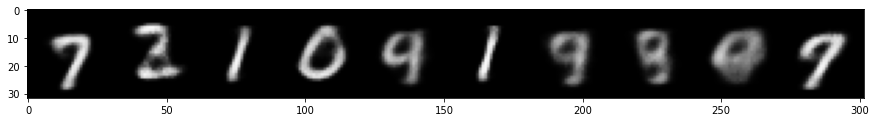

the loss after processing epoch 82 is: 8598442.5703125
showing examples ... 


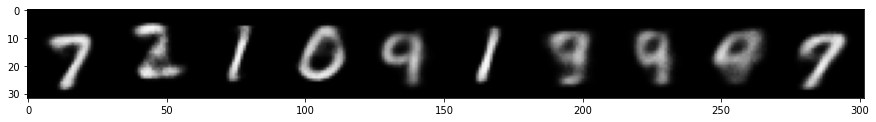

the loss after processing epoch 83 is: 8598897.1171875
showing examples ... 


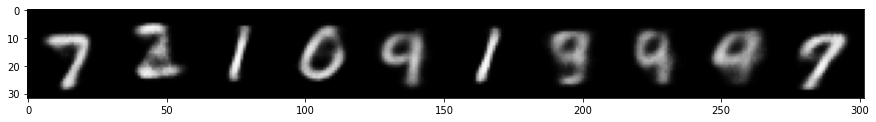

the loss after processing epoch 84 is: 8597487.9375
showing examples ... 


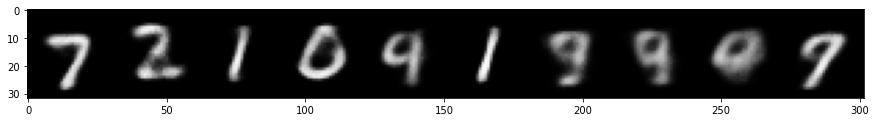

the loss after processing epoch 85 is: 8598167.9765625
showing examples ... 


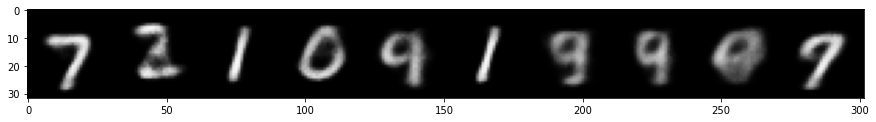

the loss after processing epoch 86 is: 8596669.734375
showing examples ... 


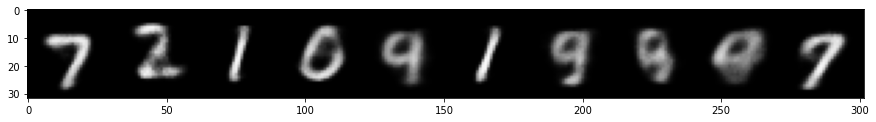

the loss after processing epoch 87 is: 8597461.3515625
showing examples ... 


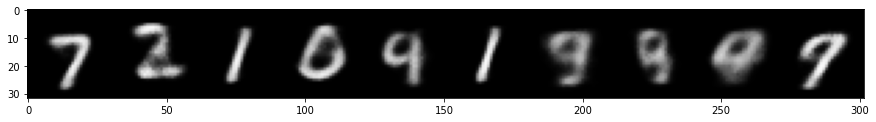

the loss after processing epoch 88 is: 8595144.6328125
showing examples ... 


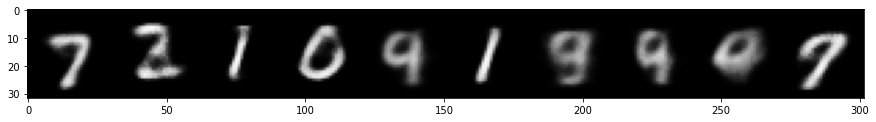

the loss after processing epoch 89 is: 8596366.765625
showing examples ... 


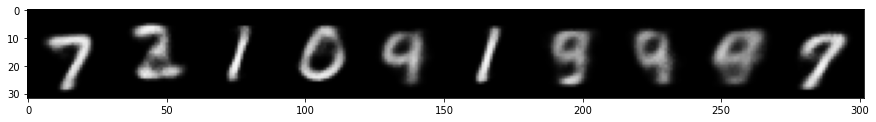

the loss after processing epoch 90 is: 8596304.4296875
showing examples ... 


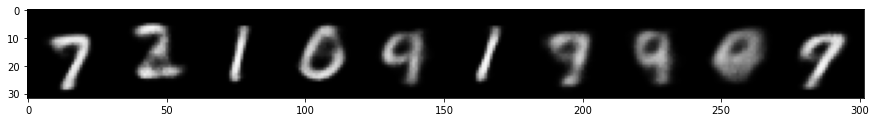

the loss after processing epoch 91 is: 8596232.640625
showing examples ... 


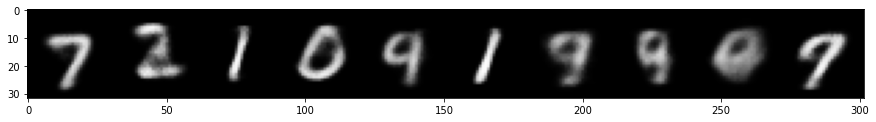

the loss after processing epoch 92 is: 8595342.671875
showing examples ... 


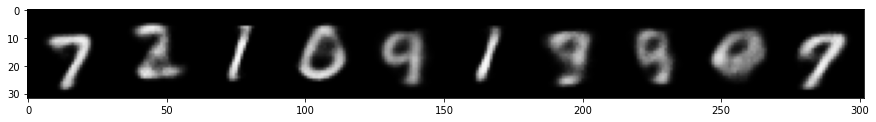

the loss after processing epoch 93 is: 8594760.046875
showing examples ... 


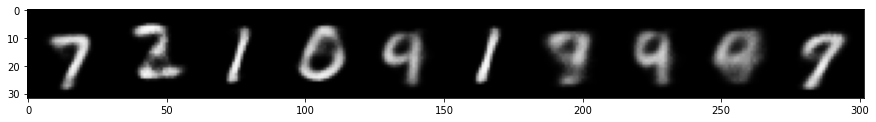

the loss after processing epoch 94 is: 8596769.203125
showing examples ... 


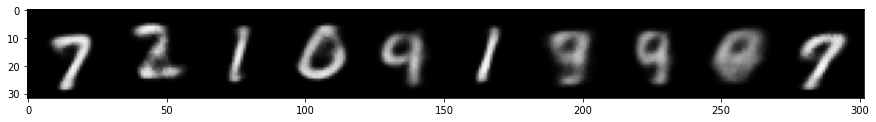

the loss after processing epoch 95 is: 8594829.7734375
showing examples ... 


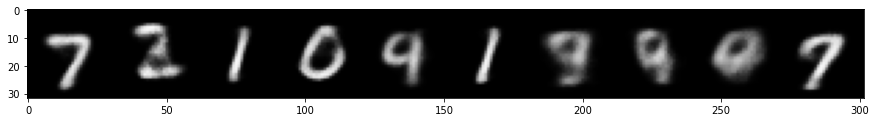

the loss after processing epoch 96 is: 8594960.8828125
showing examples ... 


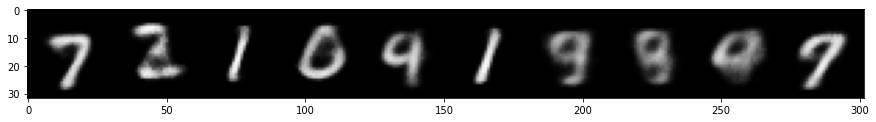

the loss after processing epoch 97 is: 8594194.4921875
showing examples ... 


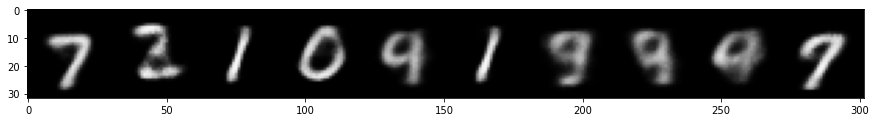

the loss after processing epoch 98 is: 8595474.5234375
showing examples ... 


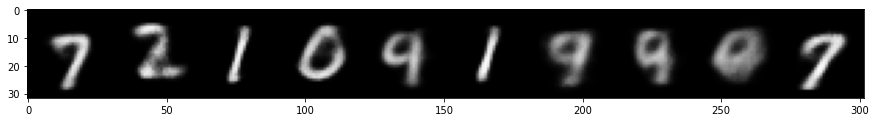

the loss after processing epoch 99 is: 8595214.8671875
showing examples ... 


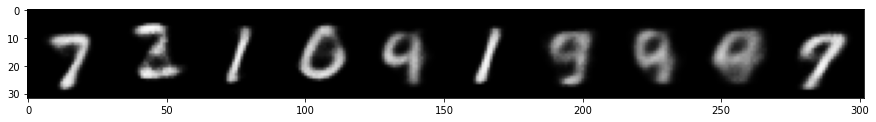

the loss after processing epoch 100 is: 8594879.21875
showing examples ... 


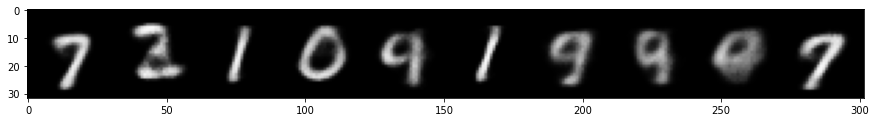

In [13]:
vae = VAE(28*28, 20)     
vae = train_vae(vae, train_loader)